# Introduction
This code defines functions to process a series of screenshots from the airhockey environment, making their backgrounds transparent to only show the puck and both pushers and overlaying them at specified intervals with the background image as the base. The final cropped image can be saved and displayed using the matplotlib library.

# Preconditions
Use the Unity-Editor with the Airhockey environment to create a series of screenshots. Use the *ExportGameStatistics*-Script. Make sure to select the *TopViewCamera* for taking screenshots. Adapt the *CullingMask*-Property of the *TopViewCamera* to only show the puck and both pushers. If the camera changes back to a player view camera during simulation deactivate this camera temporarily.
Make sure the folder where the script saves the screenshots is the same as the one specified in the *INPUT_FOLDER* variable below.

# Imports

In [1]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Constants

In [12]:
INPUT_FOLDER = r"C:\repos\trajectories"
BACKGROUND_IMAGE = r"C:\repos\proj-air-hockey-git\background_image.png"

# Trajectory visualizations


In [13]:
# write a function that takes as input a pixel value and a target pixel value and a tolerance
# and returns a boolean value indicating whether the pixel value is within the tolerance of the target pixel value
def is_within_tolerance(pixel_value, target_pixel_value, tolerance):
    '''
     This is a utility function that checks if a pixel value is within a specified tolerance of a target pixel value. It returns a boolean value indicating whether the condition is met.
    '''
    if pixel_value >= target_pixel_value - tolerance and pixel_value <= target_pixel_value + tolerance:
        return True
    else:
        return False

In [14]:
def make_transparent(image, target_color=(0,0,0), tolerance=0, transparency=255):
    '''
     This function takes an input image and makes its background transparent based on the target_color and a specified tolerance. It also sets the transparency level of the remaining non-background pixels using the provided transparency value.
    '''
    img = image.convert('RGBA')
    data = img.getdata()
    newData = []
    for item in data:
        if is_within_tolerance(item[0], target_color[0], tolerance) and \
                is_within_tolerance(item[1], target_color[1], tolerance) and \
                    is_within_tolerance(item[2], target_color[2], tolerance):
            newData.append((item[0], item[1], item[2], 0))
        else:
            newData.append((item[0], item[1], item[2], int(transparency)))
    img.putdata(newData)
    return img

In [21]:
def overlay_images(input_folder, output_filename, step=10, save_images=False):
    '''
    This is the main function that processes a series of images in an input folder, overlays them based on a specified step, and saves the resulting image to an output file. It performs the following steps:

    a. Reads image files from the input folder and sorts them based on their modification time.

    b. Opens and converts the oldest image (base image) to an RGBA format.

    c. Iterates through the rest of the images, skipping images according to the specified step, and overlays them on the base image by making their backgrounds transparent and adjusting their transparency based on their position in the sequence.

    d. After processing all images, the function crops the width of the final image and saves it if the 'save_images' parameter is set to True. Finally, it displays the resulting image using the matplotlib library.
    '''
    # Get a list of all image files in the input folder
    image_files = glob.glob(os.path.join(input_folder, "*.png"))
    # Sort the list by modification time (oldest first)
    image_files.sort(key=os.path.getmtime, reverse=True)

    
    # Read the base image
    base_image = Image.open(BACKGROUND_IMAGE).convert("RGBA")
    base_width, base_height = base_image.size

    # Iterate through the rest of the images
    for idx, img_path in enumerate(image_files[1:], 1):
        # skip step image(s)
        if idx % step == 0:
            img = Image.open(img_path).convert("RGBA")
            img = img.resize((base_width, base_height), resample=Image.Resampling.LANCZOS)

            # Calculate the transparency for the current image
            transparency = 255 * (1 - (idx / len(image_files)))
            # make background transparent
            img = make_transparent(img, target_color=(81,81,81), tolerance=2, transparency=transparency)

            # Overlay the current image on the base image
            base_image = Image.alpha_composite(base_image, img)

    # crop the image width
    base_image = base_image.crop((450, 0, 950, base_image.size[1]))
    # Save the resulting image
    if save_images:
        base_image.save(output_filename)

    # use matplotlib to display the image    
    plt.imshow(base_image)

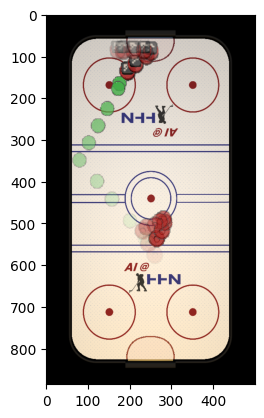

In [29]:
overlay_images(INPUT_FOLDER, "output.png", 2, False)